In [24]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout,Bidirectional, GlobalAveragePooling1D,GRU,Flatten
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
from tcn import TCN
from keras_self_attention import SeqSelfAttention
import tensorflow as tf
import math
import keras_tuner as kt

In [25]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,50130000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,19236000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,19514000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,18369400,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [26]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [27]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 18)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

         Volume  unrate  psr       m2    dspic      pce    

In [28]:
ticker='TSLA'

In [29]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,71466000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,80527500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,93928500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,44526000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,51637500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [30]:
#putting the close column on the last position
df=df[['Date', 'p_sentiment', 'Open', 'High', 'Low',
       'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer',
       'tcs', 'indpro', 'ccpi', 'Close']]

In [31]:
dates = pd.to_datetime(df['Date'])

In [32]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'Volume',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [33]:
df_for_training = df[cols].astype(float)

In [34]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [35]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [36]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [37]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [38]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [39]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1251, 7, 17)
(1251, 1)


In [40]:
import math as m
def n_layers(ks):
    n=m.ceil(m.log2((((n_past-1)*(2-1))/(ks-1))+1))
    return n

In [41]:
def build_model(hp):
    hp_ks=hp.Int('kernel_size',min_value=3,max_value=(n_past-1),step=1)
    hp_nb=hp.Int('nb_filters',min_value=16,max_value=256,step=16)
    hp_dp=hp.Choice('dropout_rate',[0.2,0.3,0.4,0.5])
    model=Sequential()
    model.add(Bidirectional(
            TCN(
                input_shape=(X.shape[1],X.shape[2]),
                kernel_size=hp_ks,
                return_sequences=False,
                dilations=[2**i for i in range(0,n_layers(hp_ks))],
                activation='relu',
                nb_filters=hp_nb,
                padding='causal',
                dropout_rate=hp_dp,
                kernel_initializer='he_normal',
                use_skip_connections=True)))

    model.add(Dense(y.shape[1]))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),loss='mse')
    return model

early_stop=EarlyStopping(monitor='val_loss',patience=20)

In [42]:

tuner = kt.GridSearch(build_model,
                     objective='val_loss',
                     project_name='bi_tcn_tuning',
                     )

Reloading Tuner from ./bi_tcn_tuning/tuner0.json


In [43]:
tuner.search(X, y, epochs=1000, validation_split=0.2, callbacks=[early_stop])

In [44]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'kernel_size': 6, 'nb_filters': 176, 'dropout_rate': 0.2}


In [45]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))
def forecast_bias(y_true, y_pred):
    return 100 * (np.mean(y_pred) - np.mean(y_true)) / np.mean(y_true)

Epoch 1/1000


3/3 [==============================] - 2s 87ms/step - loss: 0.2192 - val_loss: 0.1366
Epoch 2/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.2124 - val_loss: 0.0061
Epoch 3/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.1231 - val_loss: 0.1015
Epoch 4/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.1713 - val_loss: 0.0205
Epoch 5/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.1384 - val_loss: 0.0101
Epoch 6/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.1604 - val_loss: 0.0034
Epoch 7/1000
3/3 [==============================] - 0s 13ms/step - loss: 0.0959 - val_loss: 0.0157
Epoch 8/1000
3/3 [==============================] - 0s 14ms/step - loss: 0.1281 - val_loss: 0.0156
Epoch 9/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0977 - val_loss: 0.0027
Epoch 10/1000
3/3 [==============================] - 0s 15ms/step - loss: 0.0900 - val_loss: 0.0031
Epoch 11/1000
3/3 [===

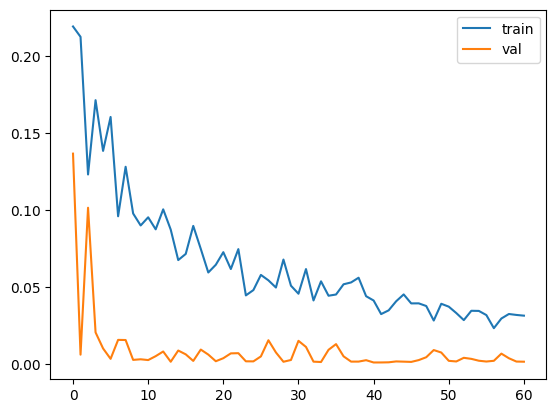

4/4 [==============================] - 0s 48ms/step
train mae: 1.3809584256435157
val mae: 0.6133160608056639
train smape: 8.305989166342963
val smape: 3.425811492897881
train forecast bias: -7.93474190299493
val forecast bias: -2.8977184188120404


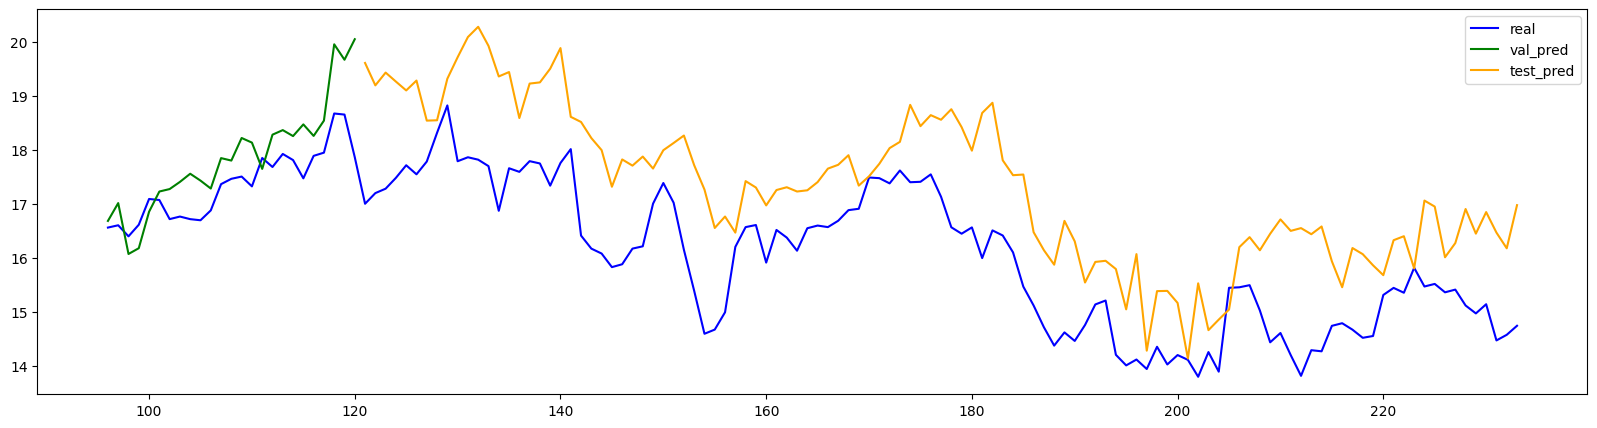

Epoch 1/1000
6/6 [==============================] - 2s 95ms/step - loss: 0.2878 - val_loss: 0.0056
Epoch 2/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.3090 - val_loss: 0.0553
Epoch 3/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.1677 - val_loss: 0.0058
Epoch 4/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.2133 - val_loss: 0.0236
Epoch 5/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.1163 - val_loss: 0.0071
Epoch 6/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.1721 - val_loss: 0.0071
Epoch 7/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.1246 - val_loss: 0.0034
Epoch 8/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.1264 - val_loss: 0.0039
Epoch 9/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0918 - val_loss: 0.0038
Epoch 10/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.1103 - val_loss: 0.0028
Epoch 11/

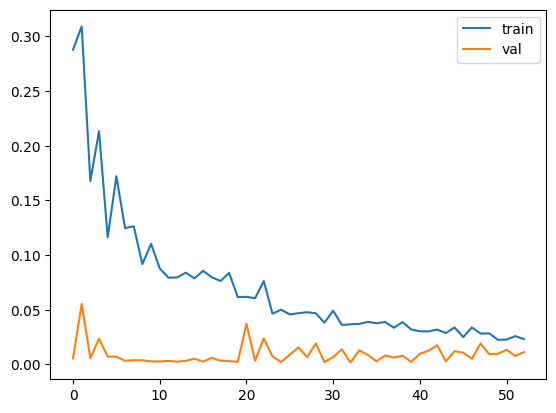

4/4 [==============================] - 0s 3ms/step
train mae: 0.9614918551198235
val mae: 1.8850628154335836
train smape: 6.907368198547018
val smape: 13.761398789597937
train forecast bias: -2.267255592932005
val forecast bias: 14.705948066916624


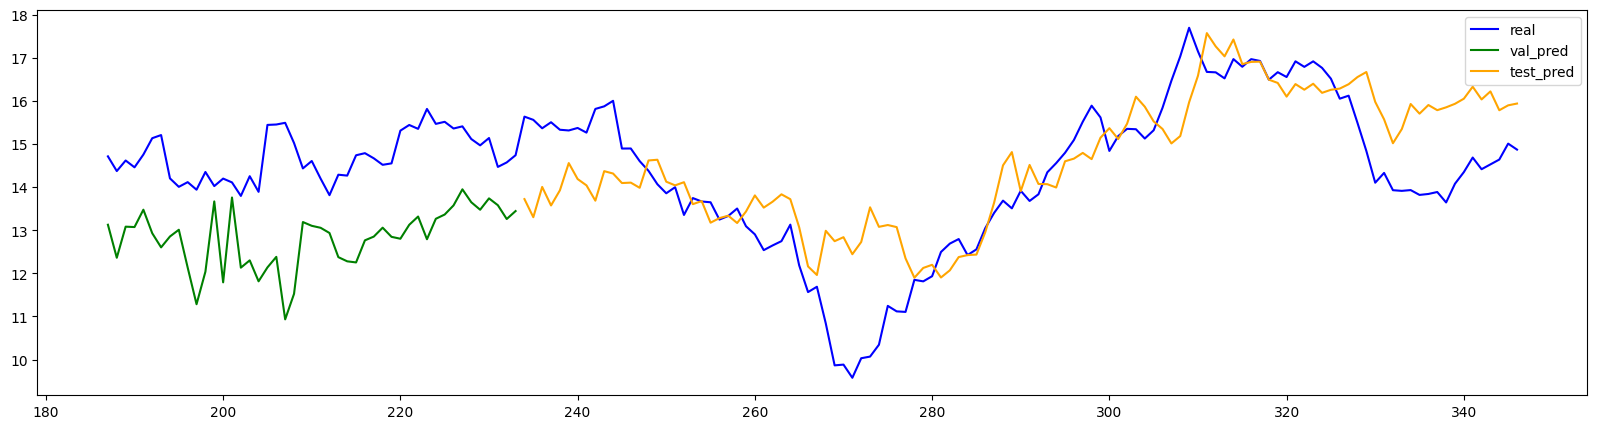

Epoch 1/1000
9/9 [==============================] - 2s 91ms/step - loss: 0.3073 - val_loss: 0.0566
Epoch 2/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.1606 - val_loss: 0.0113
Epoch 3/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.1344 - val_loss: 0.0271
Epoch 4/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.1264 - val_loss: 0.0223
Epoch 5/1000
9/9 [==============================] - 0s 9ms/step - loss: 0.1352 - val_loss: 0.0084
Epoch 6/1000
9/9 [==============================] - 0s 11ms/step - loss: 0.1148 - val_loss: 0.0047
Epoch 7/1000
9/9 [==============================] - 0s 10ms/step - loss: 0.1202 - val_loss: 0.0099
Epoch 8/1000
9/9 [==============================] - 0s 8ms/step - loss: 0.1008 - val_loss: 0.0337
Epoch 9/1000
9/9 [==============================] - 0s 9ms/step - loss: 0.1359 - val_loss: 0.0078
Epoch 10/1000
9/9 [==============================] - 0s 9ms/step - loss: 0.0913 - val_loss: 0.0060
Epoch 11/1000

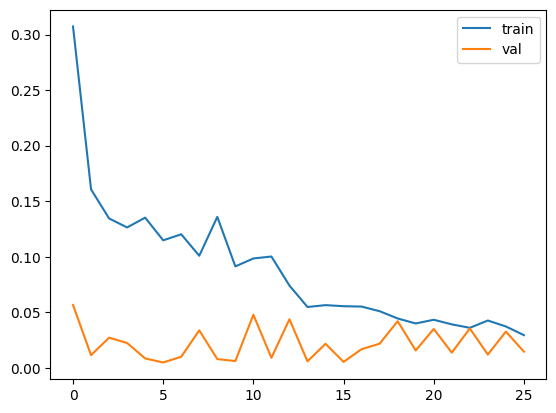

4/4 [==============================] - 0s 3ms/step
train mae: 3.10097740963286
val mae: 2.0917859154192247
train smape: 24.787953764353308
val smape: 15.294876494859622
train forecast bias: 28.048191054328438
val forecast bias: 16.30000860069138


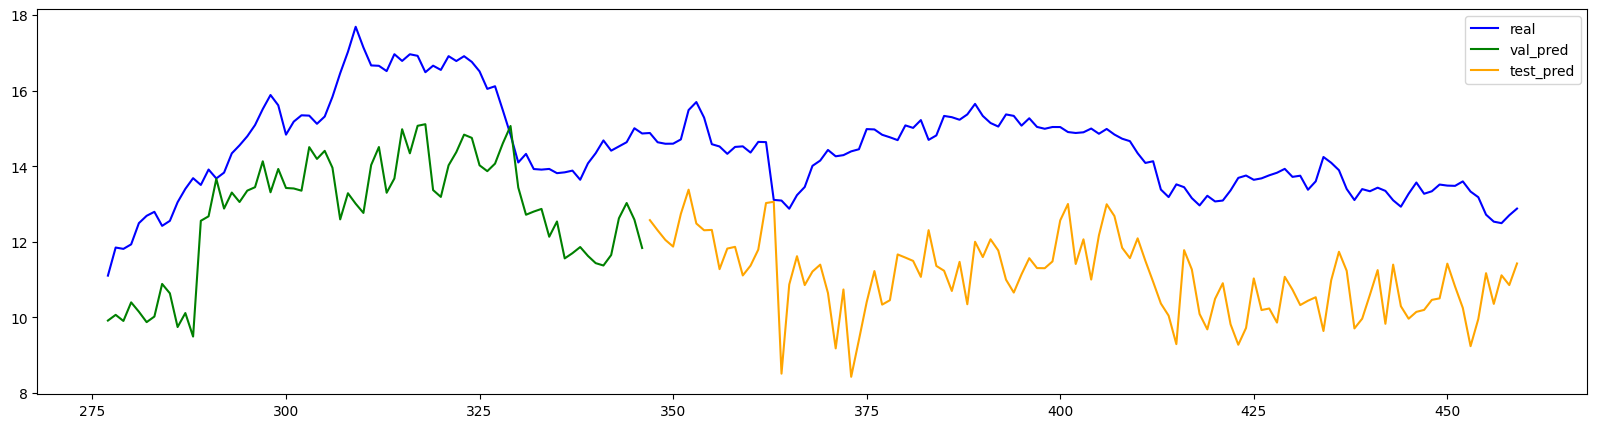

Epoch 1/1000
12/12 [==============================] - 2s 55ms/step - loss: 0.2260 - val_loss: 0.1576
Epoch 2/1000
12/12 [==============================] - 0s 8ms/step - loss: 0.2190 - val_loss: 0.3329
Epoch 3/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.1735 - val_loss: 0.0215
Epoch 4/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.1961 - val_loss: 0.0084
Epoch 5/1000
12/12 [==============================] - 0s 8ms/step - loss: 0.1586 - val_loss: 0.2120
Epoch 6/1000
12/12 [==============================] - 0s 8ms/step - loss: 0.4041 - val_loss: 0.0053
Epoch 7/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.3208 - val_loss: 0.1361
Epoch 8/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.1436 - val_loss: 0.0304
Epoch 9/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0916 - val_loss: 0.0049
Epoch 10/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0629 - val_loss: 0.

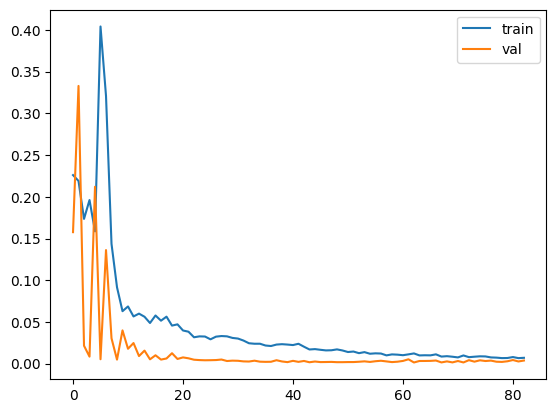

4/4 [==============================] - 0s 3ms/step
train mae: 1.7649701971981084
val mae: 1.0100794522539223
train smape: 10.908521256912246
val smape: 7.290701883836307
train forecast bias: 11.659486923148815
val forecast bias: 7.585063362635815


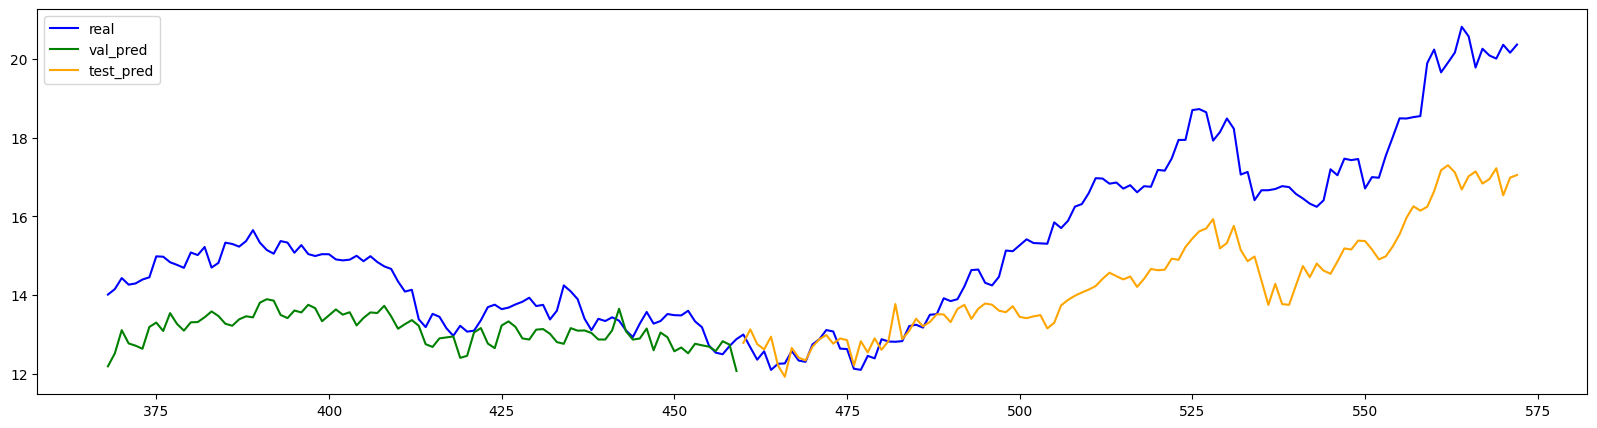

Epoch 1/1000
15/15 [==============================] - 2s 52ms/step - loss: 0.2701 - val_loss: 0.7106
Epoch 2/1000
15/15 [==============================] - 0s 10ms/step - loss: 0.3187 - val_loss: 0.0112
Epoch 3/1000
15/15 [==============================] - 0s 10ms/step - loss: 0.1689 - val_loss: 0.0027
Epoch 4/1000
15/15 [==============================] - 0s 10ms/step - loss: 0.1137 - val_loss: 0.0376
Epoch 5/1000
15/15 [==============================] - 0s 9ms/step - loss: 0.1764 - val_loss: 0.2029
Epoch 6/1000
15/15 [==============================] - 0s 9ms/step - loss: 0.0951 - val_loss: 0.0285
Epoch 7/1000
15/15 [==============================] - 0s 9ms/step - loss: 0.1324 - val_loss: 0.0025
Epoch 8/1000
15/15 [==============================] - 0s 10ms/step - loss: 0.0832 - val_loss: 0.1111
Epoch 9/1000
15/15 [==============================] - 0s 9ms/step - loss: 0.1052 - val_loss: 0.0881
Epoch 10/1000
15/15 [==============================] - 0s 9ms/step - loss: 0.1007 - val_loss: 0

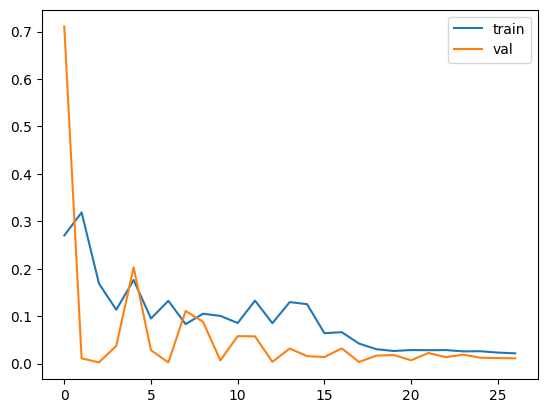

4/4 [==============================] - 0s 3ms/step
train mae: 0.9359757447823045
val mae: 1.7002133915463655
train smape: 4.1019689321243415
val smape: 12.561428022280923
train forecast bias: 0.576336154388933
val forecast bias: 11.432669693576873


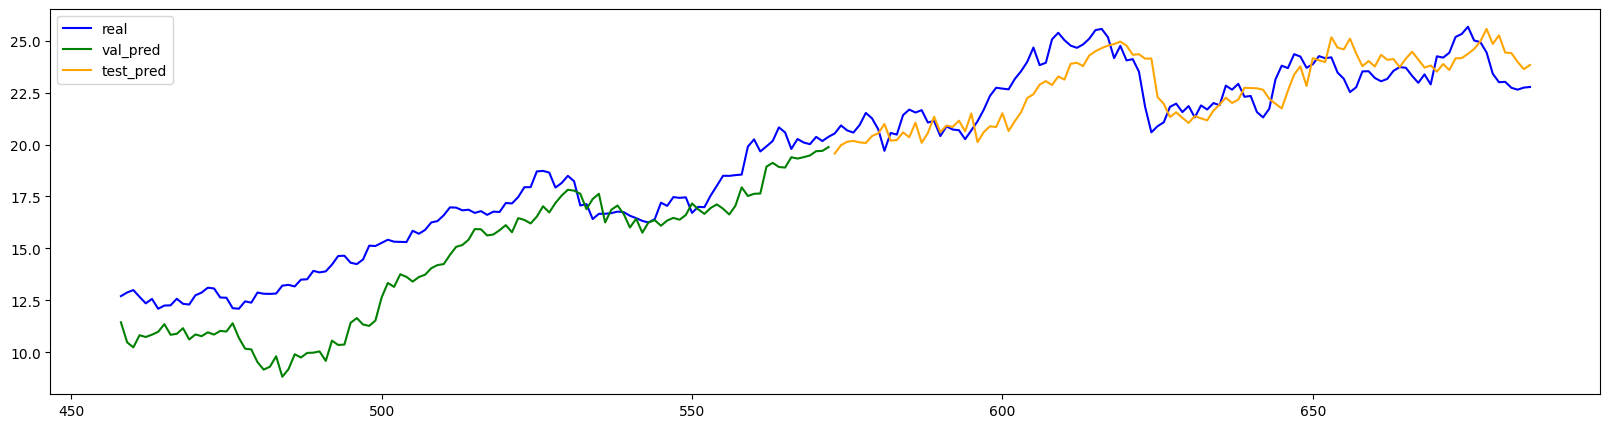

Epoch 1/1000
18/18 [==============================] - 2s 44ms/step - loss: 0.2337 - val_loss: 0.0700
Epoch 2/1000
18/18 [==============================] - 0s 10ms/step - loss: 0.1870 - val_loss: 0.1890
Epoch 3/1000
18/18 [==============================] - 0s 9ms/step - loss: 0.1421 - val_loss: 0.0106
Epoch 4/1000
18/18 [==============================] - 0s 9ms/step - loss: 0.3107 - val_loss: 0.2803
Epoch 5/1000
18/18 [==============================] - 0s 9ms/step - loss: 0.2780 - val_loss: 0.1558
Epoch 6/1000
18/18 [==============================] - 0s 9ms/step - loss: 0.7989 - val_loss: 0.6479
Epoch 7/1000
18/18 [==============================] - 0s 9ms/step - loss: 0.4235 - val_loss: 0.3318
Epoch 8/1000
18/18 [==============================] - 0s 9ms/step - loss: 0.2895 - val_loss: 0.0079
Epoch 9/1000
18/18 [==============================] - 0s 9ms/step - loss: 0.0580 - val_loss: 0.0625
Epoch 10/1000
18/18 [==============================] - 0s 8ms/step - loss: 0.0461 - val_loss: 0.03

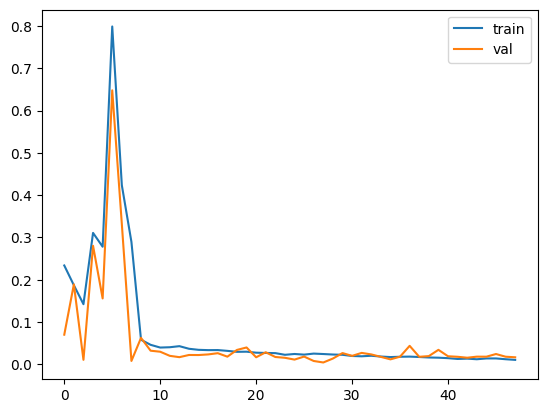

4/4 [==============================] - 0s 4ms/step
train mae: 0.9398871039358494
val mae: 2.215467885139355
train smape: 4.16974102145029
val smape: 10.763226950414655
train forecast bias: -2.9354101089453084
val forecast bias: 10.612794426441752


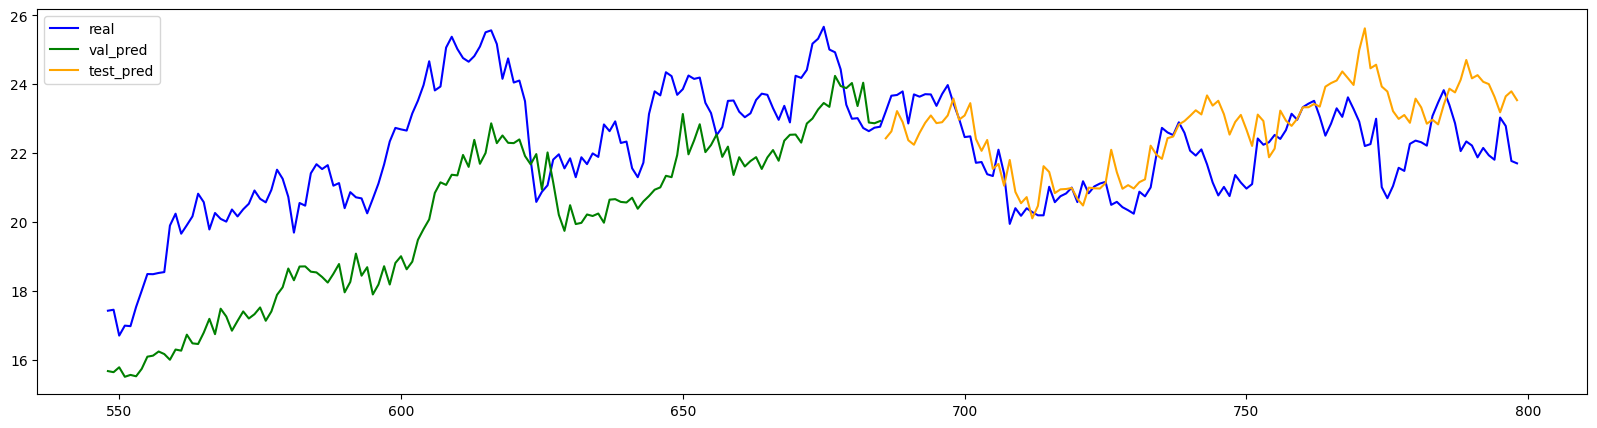

Epoch 1/1000
20/20 [==============================] - 2s 40ms/step - loss: 0.7848 - val_loss: 0.1862
Epoch 2/1000
20/20 [==============================] - 0s 10ms/step - loss: 0.5321 - val_loss: 0.0653
Epoch 3/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.2090 - val_loss: 0.0104
Epoch 4/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.1682 - val_loss: 0.0325
Epoch 5/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.2769 - val_loss: 0.1466
Epoch 6/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.4649 - val_loss: 0.0271
Epoch 7/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.6032 - val_loss: 0.8794
Epoch 8/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.9091 - val_loss: 0.1450
Epoch 9/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.3999 - val_loss: 0.1820
Epoch 10/1000
20/20 [==============================] - 0s 8ms/step - loss: 0.2532 - val_loss: 0.08

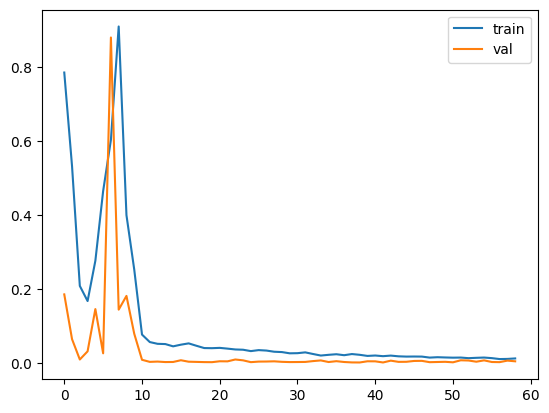

4/4 [==============================] - 0s 3ms/step
train mae: 1.0367657414874862
val mae: 1.1842773254058838
train smape: 4.9458128967299055
val smape: 5.329915209660637
train forecast bias: -3.4603033250893898
val forecast bias: 5.148264645360962


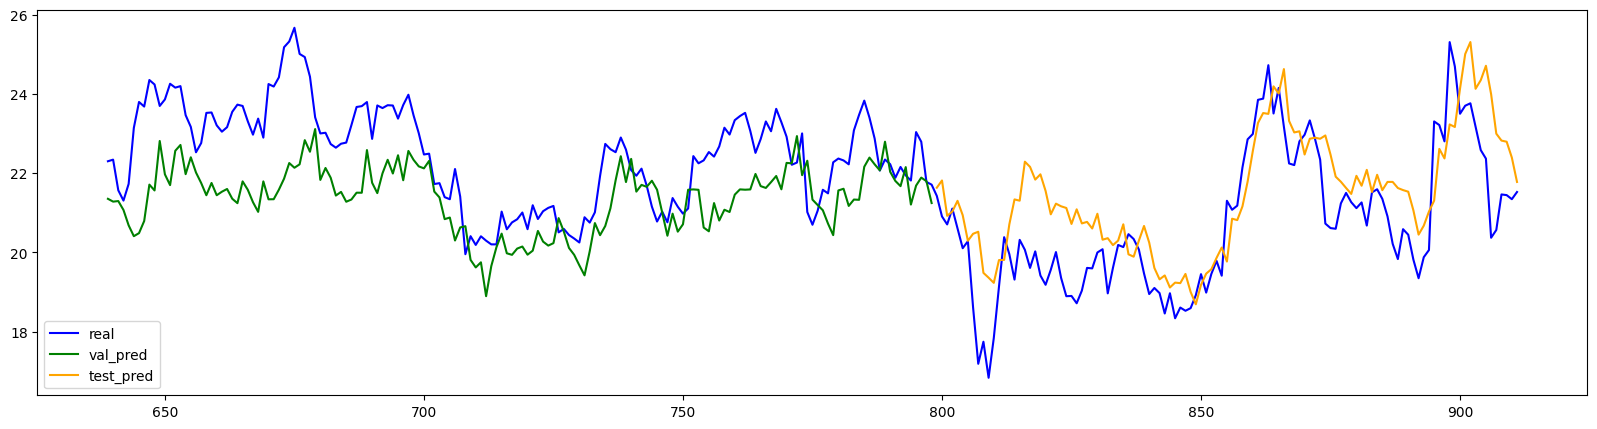

Epoch 1/1000
23/23 [==============================] - 2s 35ms/step - loss: 0.4563 - val_loss: 0.1560
Epoch 2/1000
23/23 [==============================] - 0s 10ms/step - loss: 0.3675 - val_loss: 0.5211
Epoch 3/1000
23/23 [==============================] - 0s 9ms/step - loss: 0.2817 - val_loss: 0.0493
Epoch 4/1000
23/23 [==============================] - 0s 8ms/step - loss: 1.6124 - val_loss: 0.1263
Epoch 5/1000
23/23 [==============================] - 0s 8ms/step - loss: 1.3901 - val_loss: 0.3925
Epoch 6/1000
23/23 [==============================] - 0s 8ms/step - loss: 1.4302 - val_loss: 0.3861
Epoch 7/1000
23/23 [==============================] - 0s 8ms/step - loss: 0.2056 - val_loss: 0.0788
Epoch 8/1000
23/23 [==============================] - 0s 8ms/step - loss: 0.0964 - val_loss: 0.0103
Epoch 9/1000
23/23 [==============================] - 0s 8ms/step - loss: 0.0633 - val_loss: 0.0129
Epoch 10/1000
23/23 [==============================] - 0s 9ms/step - loss: 0.0629 - val_loss: 0.00

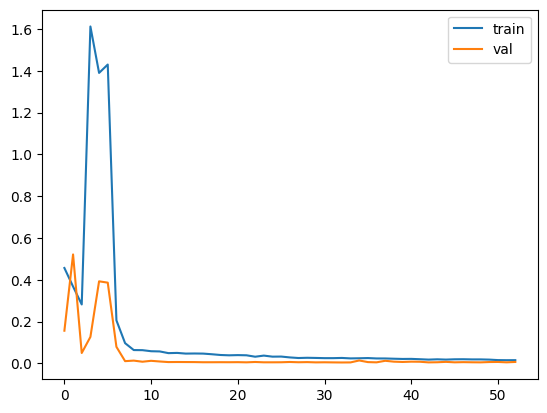

4/4 [==============================] - 0s 3ms/step
train mae: 1.600808601207092
val mae: 1.2572686123353716
train smape: 7.6207010395947155
val smape: 5.953317988064233
train forecast bias: -2.1425341884813105
val forecast bias: 5.083001852177292


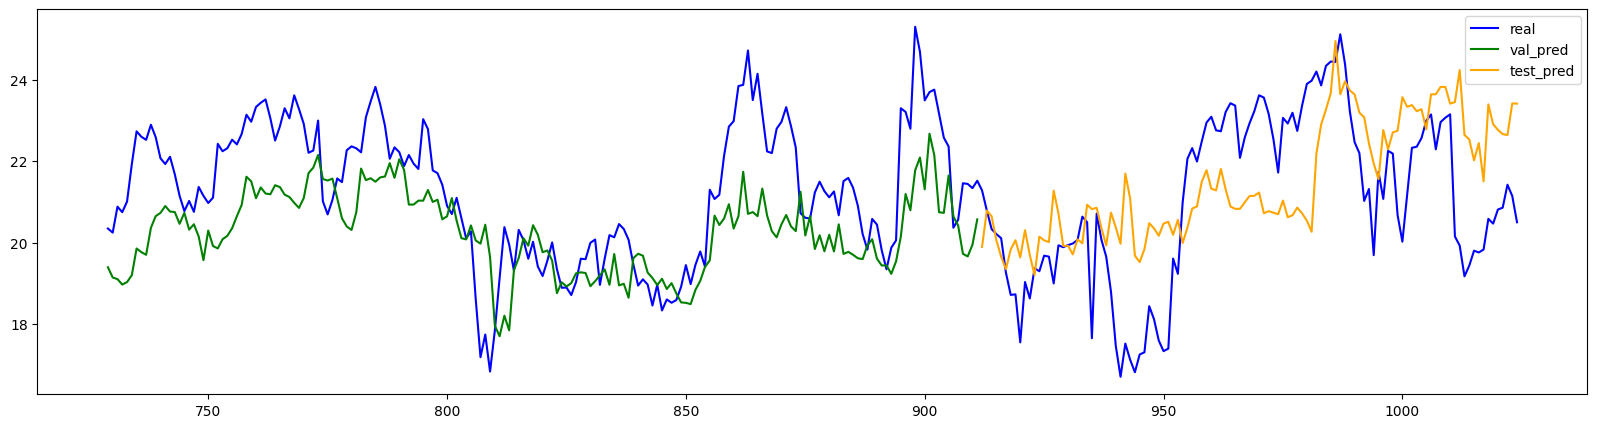

Epoch 1/1000
26/26 [==============================] - 2s 30ms/step - loss: 0.4118 - val_loss: 0.0247
Epoch 2/1000
26/26 [==============================] - 0s 8ms/step - loss: 0.4998 - val_loss: 1.0108
Epoch 3/1000
26/26 [==============================] - 0s 10ms/step - loss: 0.3017 - val_loss: 0.9022
Epoch 4/1000
26/26 [==============================] - 0s 8ms/step - loss: 0.2756 - val_loss: 0.0655
Epoch 5/1000
26/26 [==============================] - 0s 9ms/step - loss: 1.2795 - val_loss: 0.3454
Epoch 6/1000
26/26 [==============================] - 0s 8ms/step - loss: 1.1235 - val_loss: 0.5264
Epoch 7/1000
26/26 [==============================] - 0s 8ms/step - loss: 1.0910 - val_loss: 0.0217
Epoch 8/1000
26/26 [==============================] - 0s 8ms/step - loss: 0.2370 - val_loss: 0.2373
Epoch 9/1000
26/26 [==============================] - 0s 8ms/step - loss: 0.1163 - val_loss: 0.0838
Epoch 10/1000
26/26 [==============================] - 0s 8ms/step - loss: 0.0449 - val_loss: 0.05

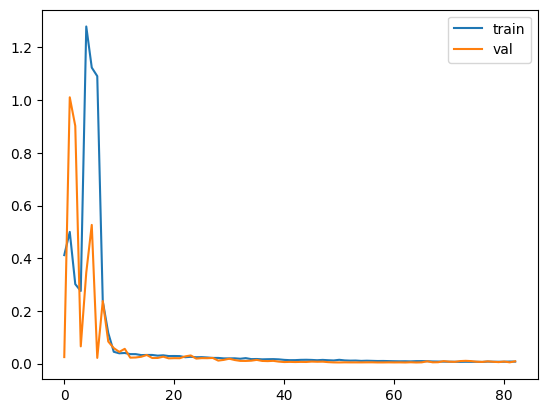

4/4 [==============================] - 0s 4ms/step
train mae: 2.412728151732318
val mae: 1.5578775209139195
train smape: 14.238678829679378
val smape: 7.630333673473228
train forecast bias: -9.749544157208575
val forecast bias: 6.795652412071666


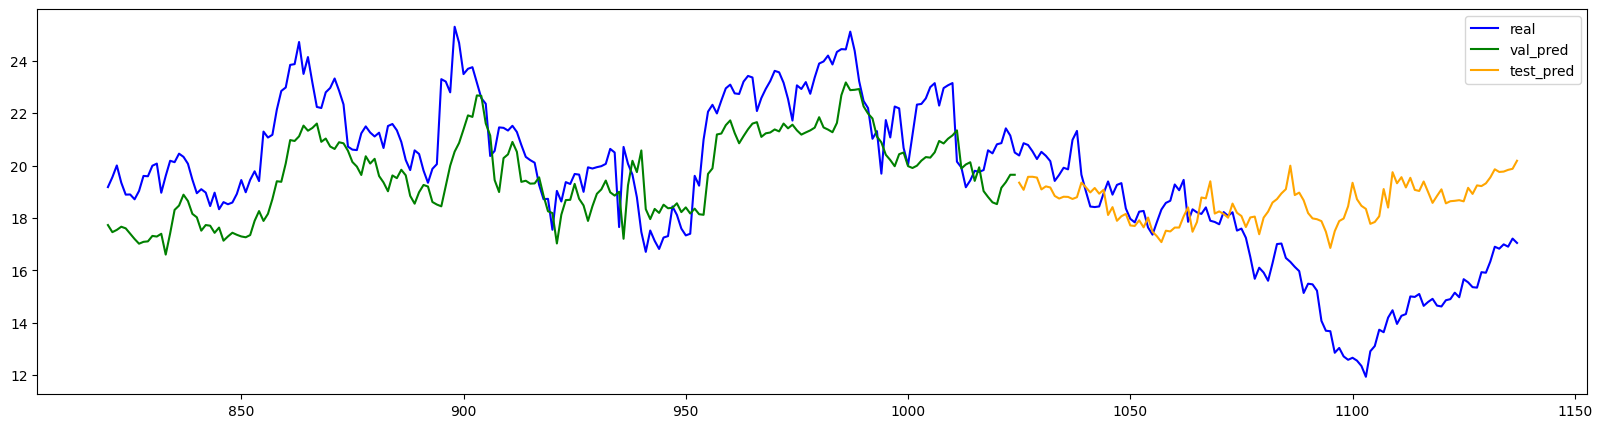

Epoch 1/1000
29/29 [==============================] - 2s 30ms/step - loss: 0.3212 - val_loss: 0.1419
Epoch 2/1000
29/29 [==============================] - 0s 8ms/step - loss: 0.3532 - val_loss: 0.4521
Epoch 3/1000
29/29 [==============================] - 0s 8ms/step - loss: 0.2502 - val_loss: 0.0737
Epoch 4/1000
29/29 [==============================] - 0s 8ms/step - loss: 0.7060 - val_loss: 0.5826
Epoch 5/1000
29/29 [==============================] - 0s 7ms/step - loss: 0.7511 - val_loss: 1.2805
Epoch 6/1000
29/29 [==============================] - 0s 8ms/step - loss: 0.7075 - val_loss: 0.3851
Epoch 7/1000
29/29 [==============================] - 0s 8ms/step - loss: 0.8110 - val_loss: 0.0518
Epoch 8/1000
29/29 [==============================] - 0s 8ms/step - loss: 0.3280 - val_loss: 0.0249
Epoch 9/1000
29/29 [==============================] - 0s 8ms/step - loss: 0.1531 - val_loss: 0.0196
Epoch 10/1000
29/29 [==============================] - 0s 8ms/step - loss: 0.0708 - val_loss: 0.050

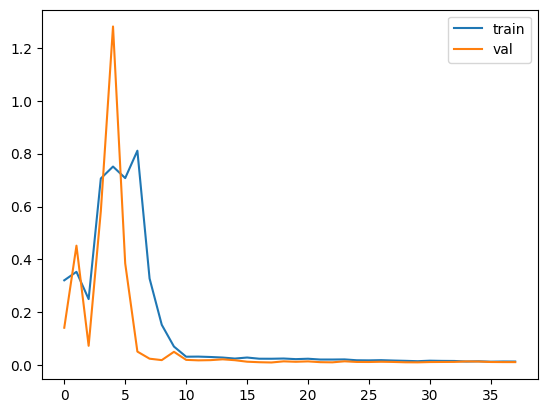

4/4 [==============================] - 0s 3ms/step
train mae: 1.8647935972857181
val mae: 1.7263852191619873
train smape: 10.32214945890075
val smape: 9.345773018711325
train forecast bias: -7.359214770178855
val forecast bias: -0.3519113382093074


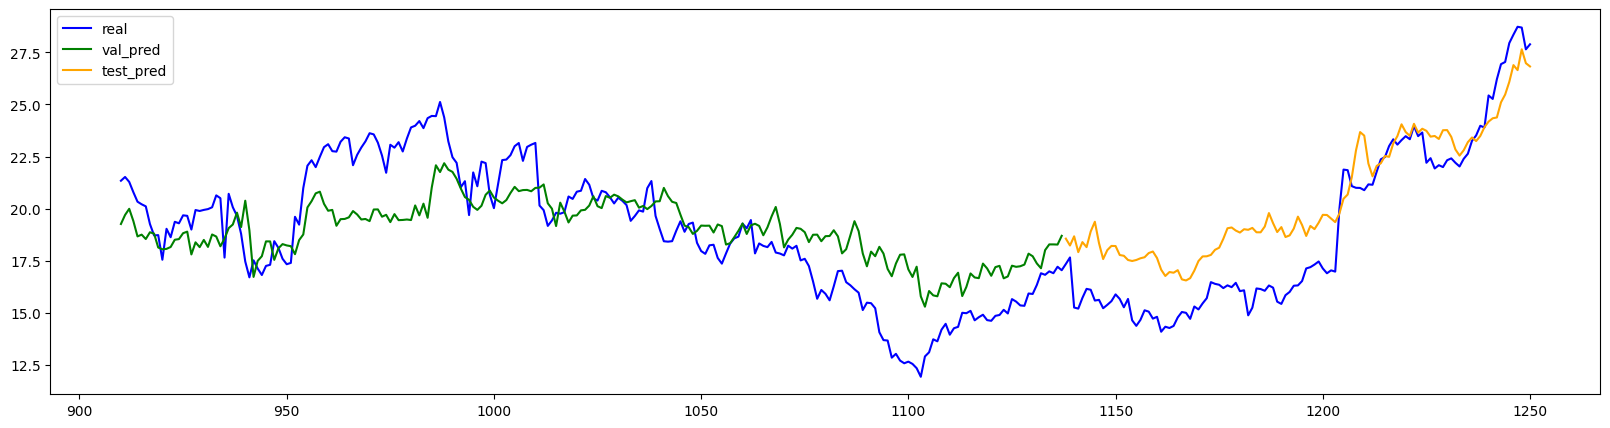

In [46]:
tscv = TimeSeriesSplit(n_splits=10)
t_maes=[]
v_maes=[]
t_smapes=[]
v_smapes=[]
t_forecast_biases=[]
v_forecast_biases=[]
for train_index, test_index in tscv.split(X):
    X_tmp, X_test = X[train_index], X[test_index]
    y_tmp, y_test= y[train_index], y[test_index]
    val_split = int(len(train_index) * 0.8)  # Adjust the validation split percentage as needed
    X_train, x_val = X_tmp[:val_split], X_tmp[val_split:]
    y_train, y_val = y_tmp[:val_split], y_tmp[val_split:]

    model=model = tuner.hypermodel.build(best_hps)
    history=model.fit(X_train,y_train,epochs=1000,validation_data=(x_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()

    y_test=np.repeat(y_test,X.shape[2],axis=1)
    y_test=scaler.inverse_transform(y_test)[:,-1] 
    y_val=np.repeat(y_val,X.shape[2],axis=1)
    y_val=scaler.inverse_transform(y_val)[:,-1]

    y_val_pred=model.predict(x_val)
    val_pred=np.repeat(y_val_pred,X.shape[2],axis=1)
    val_pred=scaler.inverse_transform(val_pred)[:,-1]

    y_pred=model.predict(X_test)
    pred=np.repeat(y_pred,X_train.shape[2],axis=1)
    pred=scaler.inverse_transform(pred)[:,-1]
    
    v_time=range(X_train.shape[0],X_train.shape[0]+len(y_val))

    t_time=range(X_train.shape[0]+len(y_val),X_train.shape[0]+len(y_val)+len(y_test))

    r_time=range(X_train.shape[0],X_train.shape[0]+len(y_val)+len(y_test))

    t_mae=mae(pred,y_test)
    t_maes.append(t_mae)
    print('train mae:',t_mae)
    v_mae=mae(val_pred,y_val)
    v_maes.append(v_mae)
    print('val mae:',v_mae)
    t_smape=smape(pred,y_test)
    t_smapes.append(t_smape)
    print('train smape:',t_smape)
    v_smape=smape(val_pred,y_val)
    v_smapes.append(v_smape)
    print('val smape:',v_smape)

    t_forecast_bias=forecast_bias(pred,y_test)
    t_forecast_biases.append(t_forecast_bias)
    print('train forecast bias:',t_forecast_bias)
    v_forecast_bias=forecast_bias(val_pred,y_val)
    v_forecast_biases.append(v_forecast_bias)
    print('val forecast bias:',v_forecast_bias)
    

    #plotting the results
    real=np.concatenate((y_val,y_test))
    plt.figure(figsize=(20,5))
    plt.plot(r_time,real,label='real',color='blue')
    plt.plot(v_time,val_pred,label='val_pred',color='green')
    plt.plot(t_time,pred, label='test_pred',color='orange') 
    plt.legend()
    plt.show()

In [47]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirect  (None, 352)               1158784   
 ional)                                                          
                                                                 
 dense_10 (Dense)            (None, 1)                 353       
                                                                 
Total params: 1159137 (4.42 MB)
Trainable params: 1159137 (4.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
Taverage_mae=np.mean(t_maes)

print('Average MAE in testing:',Taverage_mae)

Vaverage_mae=np.mean(v_maes)

print('Average MAE in validation:',Vaverage_mae)

Taverage_smape=np.mean(t_smapes)

print('Average SMAPE in testing:',Taverage_smape)

Vaverage_smape=np.mean(v_smapes)

print('Average SMAPE in validation:',Vaverage_smape)

Taverage_forecast_bias=np.mean(t_forecast_biases)

print('Average forecast bias in testing:',Taverage_forecast_bias)

Vaverage_forecast_bias=np.mean(v_forecast_biases)

print('Average forecast bias in validation:',Vaverage_forecast_bias)

Average MAE in testing: 1.5999356828025075
Average MAE in validation: 1.5241734198415275
Average SMAPE in testing: 9.630888456463492
Average SMAPE in validation: 9.135678352379674
Average forecast bias in testing: 0.44350100860358144
Average forecast bias in validation: 7.441377330285102
